In [1]:
import tensorflow as tf

In [2]:
import os
import cv2
import math
# import pafy - for youtube videos
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import * # create and edit video by programs
from collections import deque # deque is a double-ended queue that allows you to efficiently add and remove elements from both ends.
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import * # contains various layers used to built neural networks, dense layers, cnn layers etc...
from tensorflow.keras.models import Sequential # built linear stack layer
from tensorflow.keras.utils import to_categorical # one-hot-encodeing
from tensorflow.keras.callbacks import EarlyStopping 
# EarlyStopping is a callback in TensorFlow and Keras that is used during the training of a neural network to stop training early under certain conditions. 
# It helps prevent overfitting and can save training time
# Callbacks in Keras allow you to specify actions to be taken at different stages during training,
# such as early stopping
from tensorflow.keras.utils import plot_model # visualize architecture of keras model.

In [3]:
# set Numpy, Python & Tensorflow seeds to get consistent results.
# same random values will be selected
seed_constant = 23
np.random.seed(seed_constant) # numpy random number
random.seed(seed_constant) # python random number
tf.random.set_seed(seed_constant) # tensorflow random number

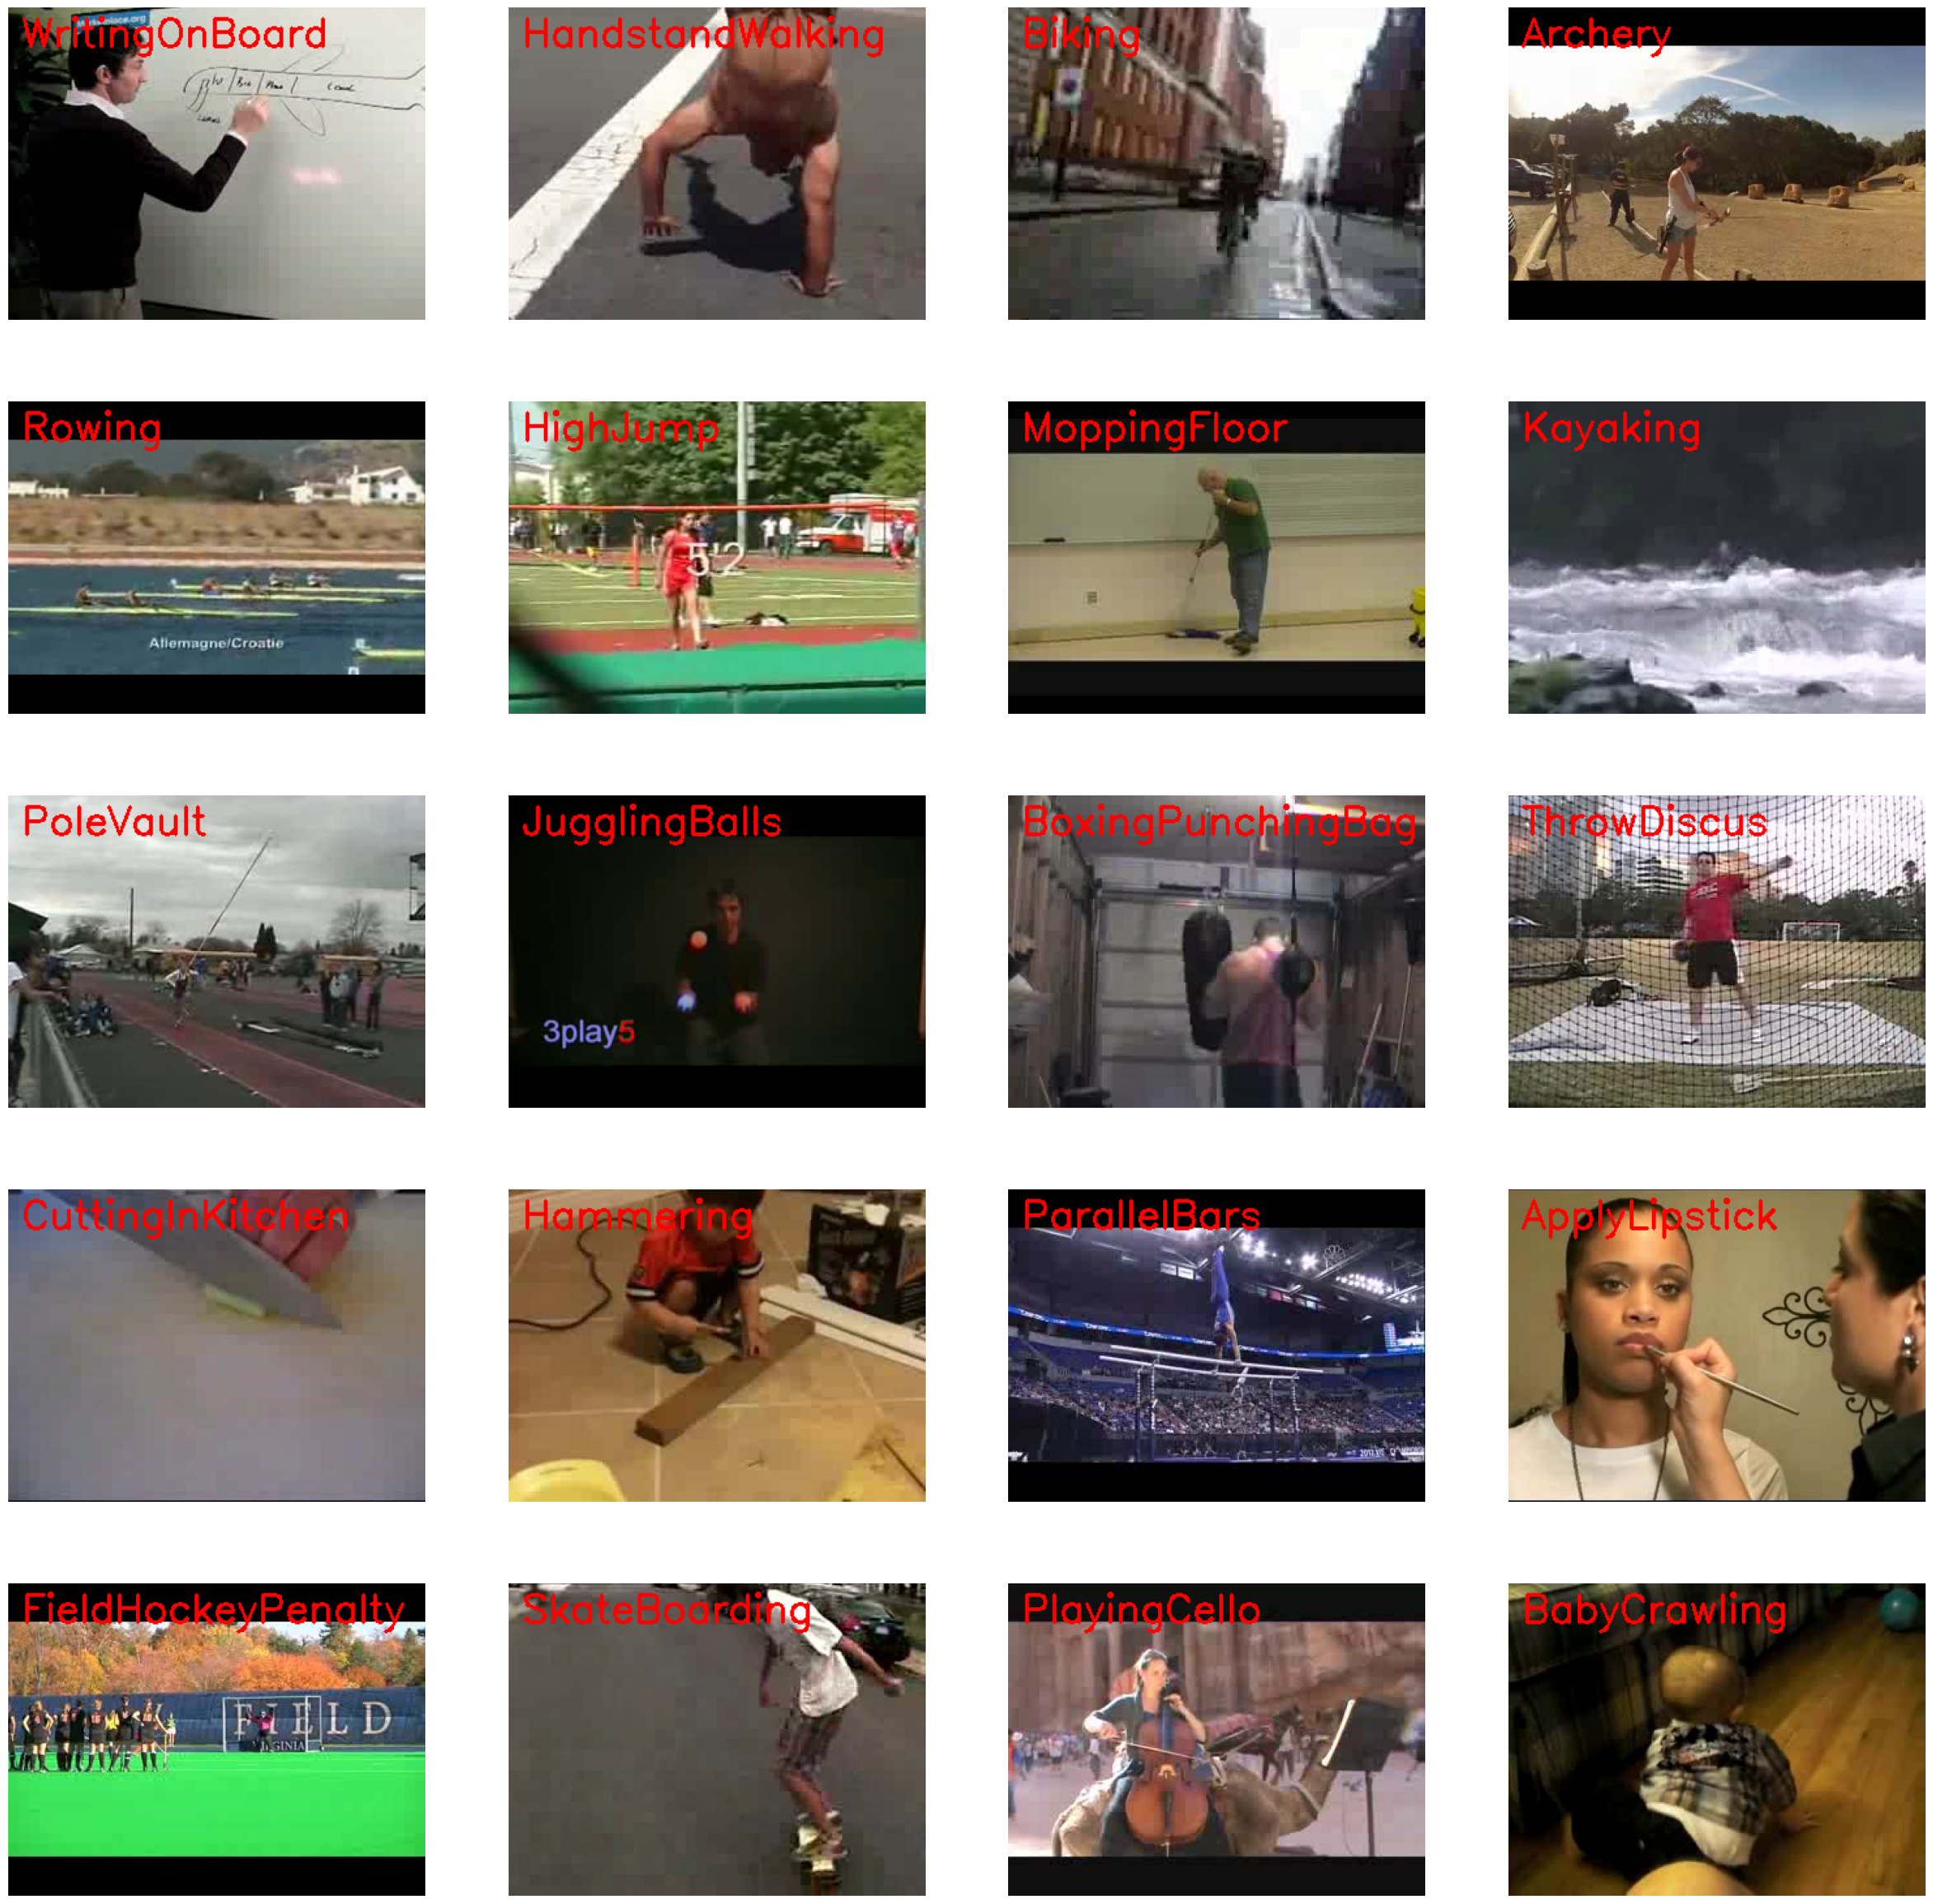

In [4]:
# sample data

# Create a Matplotlib figure
plt.figure(figsize = (30, 30)) # height and width
UCF101_path=r"D:\Datasets\UCF-101"

# Get Names of all classes in UCF50
all_classes_names = os.listdir(UCF101_path)

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)  # display 1st 20 random images from each category 

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
    # enumerate print with index

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'D:\\Datasets\\UCF-101/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'D:\\Datasets\\UCF-101/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    #  the text will be positioned at (10, 30) pixels from the top-left corner of the image.
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter) # 5 rows , 4 cols.
    plt.imshow(rgb_frame)
    plt.axis('off')

In [5]:
# read and process dataset
image_height, image_width = 64, 64
max_images_per_class = 8000

dataset_directory = "D:\\Datasets\\UCF-101"
classes_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace","HighJump"]

model_output_size = len(classes_list)

In [6]:
# extract resize and normalize images
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

In [7]:
# dataset creation
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [8]:
features, labels = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: HighJump


In [9]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [10]:
# train test split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [11]:
# construct model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 60, 60, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                              
                                                                 
 global_average_pooling2d (  (None, 64)                0         
 GlobalAveragePooling2D)                                         
                                                        

In [12]:
# compile and train
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
6400/6400 [==============================] - 392s 60ms/step - loss: 1.0384 - accuracy: 0.5941 - val_loss: 0.7401 - val_accuracy: 0.7598
Epoch 2/50
6400/6400 [==============================] - 374s 58ms/step - loss: 0.6181 - accuracy: 0.7791 - val_loss: 0.4550 - val_accuracy: 0.8684
Epoch 3/50
6400/6400 [==============================] - 365s 57ms/step - loss: 0.4487 - accuracy: 0.8475 - val_loss: 0.7432 - val_accuracy: 0.7738
Epoch 4/50
6400/6400 [==============================] - 348s 54ms/step - loss: 0.3641 - accuracy: 0.8750 - val_loss: 0.1755 - val_accuracy: 0.9478
Epoch 5/50
6400/6400 [==============================] - 345s 54ms/step - loss: 0.3217 - accuracy: 0.8921 - val_loss: 0.3159 - val_accuracy: 0.8911
Epoch 6/50
6400/6400 [==============================] - 360s 56ms/step - loss: 0.2872 - accuracy: 0.9032 - val_loss: 0.4504 - val_accuracy: 0.8623
Epoch 7/50
6400/6400 [==============================] - 359s 56ms/step - loss: 0.2644 - accuracy: 0.9116 - val_loss: 0

In [13]:
# model evaluation
model_evaluation_history = model.evaluate(features_test, labels_test)

250/250 [==============================] - 15s 56ms/step - loss: 0.0309 - accuracy: 0.9911


In [14]:
# save model
model_name="HAR_model"
model.save(model_name)

INFO:tensorflow:Assets written to: HAR_model\assets


INFO:tensorflow:Assets written to: HAR_model\assets


In [16]:
model.save('HAR_ConvLSTM_model.h5')